In [13]:
from __future__ import print_function
from __future__ import division

#Handle Imports
import cv2
import numpy as np
import math
import os
import pylab as pl
import matplotlib.pyplot as plt
import random

from os import listdir
from os.path import isfile, join
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from keras import losses
from keras import optimizers
from keras.utils import np_utils
from keras import backend as K
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

import detection

%matplotlib inline

In [17]:
windowsize = 32
batch_size = 128
epochs = 1
target_size = (32, 32)
train_path = 'data/train/classes/'
validation_path = 'data/validation/classes/'
model_path = 'models/model'

full_image_path = 'data/train/full_images/'
detection_image_path = 'data/train/full_images_detected'
detected_particles_path = "data/train/detected_particles"

In [4]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        horizontal_flip=True,
        rotation_range=.2)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        color_mode='grayscale')

validation_generator = test_datagen.flow_from_directory(
        validation_path,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale')

Found 225 images belonging to 2 classes.
Found 179 images belonging to 2 classes.


In [5]:
#Make model
'''Model creation and fitting'''

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=train_generator.image_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(train_generator.num_class, activation='softmax'))

model.compile(loss=losses.categorical_crossentropy,
              optimizer=optimizers.Adadelta(),
              metrics=['accuracy'])

In [6]:
model.fit_generator(
        train_generator,
        steps_per_epoch=2000,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_generator.n)

Epoch 1/1
2000/2000 [==============================] - 64s - loss: 0.0343 - acc: 0.9868 - val_loss: 6.3767e-05 - val_acc: 1.0000


In [7]:
# serialize model to JSON
model_json = model.to_json()
with open(os.path.join(model_path, model_name + ".json"), "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights(os.path.join(model_path, model_name + ".h5"))
print("Saved model to disk")

Saved model to disk


In [10]:
images = []
names = []
    
for f_name in os.listdir(full_image_path):
    
    # Read image.
    original = cv2.imread(os.path.join(full_image_path, f_name), 0) / 255
    
    images.append(original)
    
    file_extension = f_name.split('.')[-1]
    f_name = '_'.join(f_name.split('.')[:-1])
    
    names.append(f_name)
    
    
images = np.stack(images)

In [15]:
pyramid = [(.5, 5), (.7, 5)]

In [18]:
coordinates, particles = detection.detect_particles(images, pyramid, model_path, suppression=0)

Loaded model from disk
10980/10980 [==============================] - 1s     
8
22080/22144 [============================>.] - ETA: 0s14


In [21]:
images.shape

(8, 960, 1280)

In [23]:
coordinates.shape, particles.shape

((22, 4), (22, 32, 32, 1))

In [19]:
if not os.path.isdir(detected_particles_path):
    os.makedirs(detected_particles_path)
    
if not os.path.exists(detection_image_path):
    os.mkdir(detection_image_path)

for f_name, i in zip(names, images):
    
    img = i.copy()
    
    for c, p in zip(coordinates, particles):
        
        # Save the detected detections to disk.
        x_start = c[0]
        y_start = c[1]
        x_end = c[2]
        y_end = c[3]

        dp_f_name = '{}_{}_{}_{}_{}.{}'.format(f_name, x_start, y_start, x_end, y_end, "jpg")

        cv2.imwrite(os.path.join(detected_particles_path, dp_f_name), p)
        
        # Place square around detection.
        cv2.rectangle(img, (x_start, y_start), (x_end, y_end), (0, 255, 0), 2)

    # Save full detection image to disk.
    cv2.imwrite(os.path.join(detection_image_path, '{}.{}'.format(f_name, file_extension)), img * 255)

ValueError: num must be 1 <= num <= 15, not 0

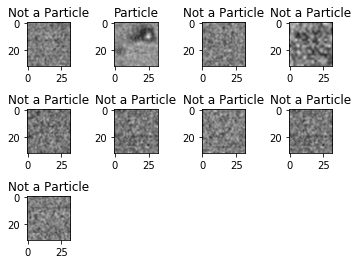

In [8]:
'''Visualize Predictions'''

X_test, y_test = next(validation_generator)

fig = plt.figure()
fig.subplots_adjust(hspace=1)

predictions = model.predict_classes(X_test, batch_size=32, verbose=0)

displays = 16

for i in range(displays):
    x = random.sample(range(1,len(X_test)), displays)
    img = np.squeeze(X_test[x[i]])
    ax = plt.subplot(341 + i)
    if(predictions[x[i]] == 1):
        ax.set_title("Particle")
    else:
        ax.set_title("Not a Particle")
    plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')

plt.show()